In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pymatgen.electronic_structure.core import Spin

In [2]:
mp_key = "bw9PJDXW6ljZz8DyLmXT49ZnMengQUwm"
mp_id = "mp-30460"

In [3]:
with MPRester(mp_key) as m:
    #récupération de la structure
    struct = m.get_structure_by_material_id(mp_id)
    #récupération de la structure de bandes électroniques
    el_bs = m.get_bandstructure_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{E\\ -\\ E_f\\ (eV)}$'>

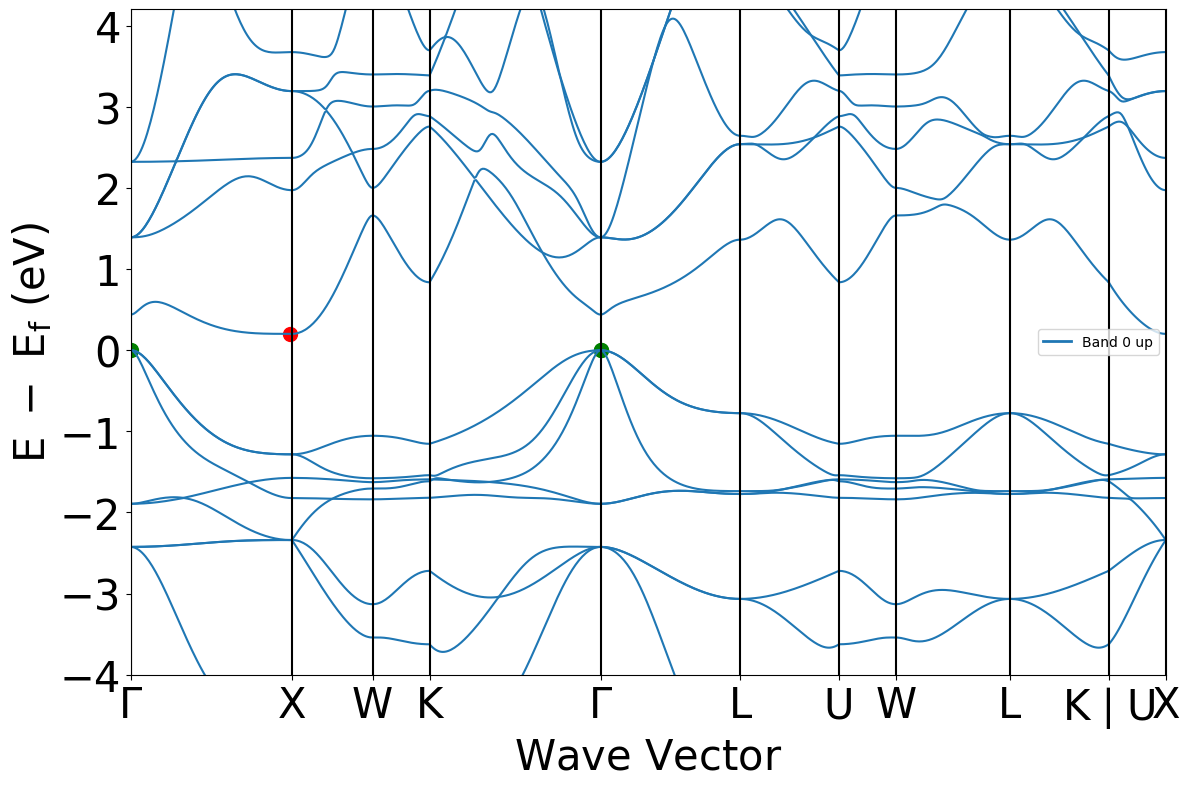

In [4]:
# visualisation
plot = BSPlotter(el_bs)
plot.get_plot(vbm_cbm_marker=True)

In [5]:
#détermination de la bande interdite
band_gap = el_bs.get_band_gap()
print(band_gap)

{'direct': False, 'energy': 0.2016, 'transition': '\\Gamma-(0.495,0.000,0.495)'}


La bande interdite est indirecte et a une largeur de 0.2016eV.

In [6]:
# Recherche de la dernière bande de valence
vbm = el_bs.get_vbm()
data = BSPlotter(el_bs).bs_plot_data()
E_0 = data.get('zero_energy')
E_vbm = vbm['energy']
kpoint_vbm = vbm['kpoint'].cart_coords

print('Energie du maximum de la bande de valence = {} eV'.format(E_vbm))
print('Sur le graphe : E-Ef = ', (E_vbm-E_0))
print('Vecteur k  en coordonnées cartésiennes =', kpoint_vbm)
print(vbm.get('band_index'))

Energie du maximum de la bande de valence = 5.9717 eV
Sur le graphe : E-Ef =  0.0
Vecteur k  en coordonnées cartésiennes = [0. 0. 0.]
defaultdict(<class 'list'>, {<Spin.up: 1>: [13, 14, 15]})


Les bandes 13, 14 et 15 contiennent l'énergie maximum de la bande de valence (5,9717eV). Ce maximum correspond aux points verts sur le graphe ci-dessus. On peut donc considérer que la dernière bande de valence est la bande 15.

In [7]:
#Recherche de la première bande de conduction
cbm = el_bs.get_cbm()
E_cbm = cbm['energy']
kpoint_cbm = cbm['kpoint'].cart_coords

print('Energie du minimum de la bande de conduction = ',E_cbm,'eV')
print('sur le graphe : E-Ef = ', (E_cbm-E_0))
print('Vecteur k (coordonnées cartésiennes) =',kpoint_cbm)
print(cbm.get('band_index'))

Energie du minimum de la bande de conduction =  6.1733 eV
sur le graphe : E-Ef =  0.2016
Vecteur k (coordonnées cartésiennes) = [0.         0.95704128 0.        ]
defaultdict(<class 'list'>, {<Spin.up: 1>: [16]})


La première bande de conduction est la bande 16, elle contient l'énergie minimum de la bande de conduction (6,1733eV). Ce minimum correspond au point rouge sur le graphe ci-dessus.

Le phénomène de dispersion fait référence à la séparation des différentes longueurs d'onde de la lumière lorsqu'elle traverse un matériau cristallin et dépend de la variation d'énergie du vectuer d'onde k. Le maximum de dispersion correspond à la partie du graphe où la pente de la courbe des bandes électroniques est la plus raide. Et inversément, un minimum de dispersion correspond à la partie du graphe où la pente de la courbe des bandes électroniques est la moins raide.

In [8]:
#directions des dispersions maximales et minimales 
x = data.get('ticks').get('distance')
x = np.array([x[0], x[1], x[3], x[5], x[7], x[9], x[11], x[13], x[15], x[17], x[18]]) 
# x = tableau avec les positions des lignes verticales
y = data.get('energy')
# y contient les énergies des différentes bandes aux différentes valeurs du vecteur d'onde k

#initialisation des tableaux
dx = np.zeros(10)
dyconduction = np.zeros(10)
dyvalence = np.zeros(10)
pconduction = np.zeros(10)
pvalence = np.zeros(10)

for i in range(10):
    # calcul des distances entre les lignes verticales
    dx[i] = x[i+1] - x[i]
    
for i in range(10):
    #calcul des différences en y entre 2 lignes verticales pour les bandes 15 et 16 
    dyvalence[i] =y.get('1')[i][15][-1] - y.get('1')[i][15][0]
    dyconduction[i] =y.get('1')[i][16][-1] - y.get('1')[i][16][0]
    
for i in range (10):
    #calcul des pentes entre les lignes verticales pour les bandes 15 et 16
    pconduction[i] = dyconduction[i]/dx[i]
    pvalence[i] = dyvalence[i]/dx[i] 
    
print("En valeur absolue:")
mxV = np.max(abs(pvalence))
print("Pente de la plus grande dispersion pour la bande de valence: ", mxV)
mxC = np.max(abs(pconduction))
print("Pente de la plus grande dispersion pour la bande de conduction: ", mxC)
mnV = np.min(abs(pvalence))
print("Pente de la plus faible dispersion pour la bande de valence: ", mnV)
mnC = np.min(abs(pconduction))
print("Pente de la plus faible dispersion pour la bande de conduction: ", mnC)

En valeur absolue:
Pente de la plus grande dispersion pour la bande de valence:  1.3270797439751012
Pente de la plus grande dispersion pour la bande de conduction:  3.0187884271893646
Pente de la plus faible dispersion pour la bande de valence:  0.29044444059444124
Pente de la plus faible dispersion pour la bande de conduction:  0.24539548293095284


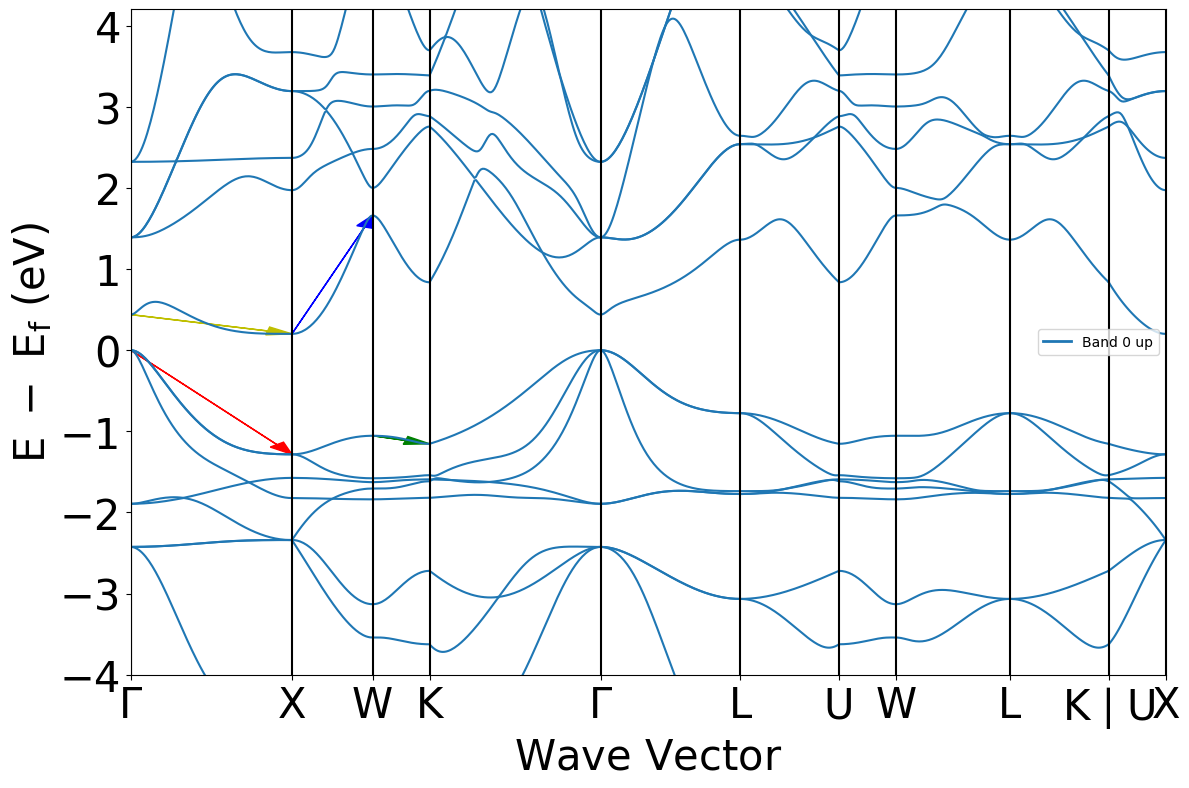

In [9]:
#plot des graphes avec les flèches représentant les dispersions maximales et minimales
BSPlotter(el_bs).get_plot()

#bande de valence, plus grande dispersion
plt.arrow(x[0], (y.get('1')[0][15])[0], dx[0], dyvalence[0], color = 'r', head_width = 0.1,length_includes_head=True)
#bande de valence, plus faible dispersion
plt.arrow(x[2], (y.get('1')[2][15])[0], dx[2], dyvalence[2], color = 'g', head_width = 0.1,length_includes_head=True)
#bande de conduction, plus grande dispersion
plt.arrow(x[1], (y.get('1')[1][16])[0], dx[1], dyconduction[1], color = 'b', head_width = 0.1,length_includes_head=True)
#bande de conduction, plus faible dispersion
plt.arrow(x[0], (y.get('1')[0][16])[0], dx[0], dyconduction[0], color = 'y', head_width = 0.1,length_includes_head=True)

plt.show()

En supposant une dispersion parabolique, la masse effective est obtenue comme : 

$$m^* = \frac{\hbar^2 k^2}{2\cdot E(k)} = \frac{\hbar^2 (k_x^2 + k_y^2 + k_z^2)}{2\cdot E(k)}$$

où E(k) est l'énergie d'un électron de vecteur d'onde k (dans la bande considérée)

In [10]:
h_bar = 6.5821e-16 #en eV

#calcul de la masse effective au sommet de la dernière bande de valence

#coordonnée du vecteur k 
k_coord_val = el_bs.get_vbm().get('kpoint').frac_coords
m_vbm = (h_bar**2 * (k_coord_val[0]**2+k_coord_val[1]**2+k_coord_val[2]**2))/(2*abs(E_vbm))
print('La masse effective au sommet de la dernière bande de valence = {} kg.'.format(m_vbm))


#calcul de la masse effective au bas de la première bande de conduction

#coordonnée du vecteur k 
k_coord_cond = el_bs.get_cbm().get('kpoint').frac_coords
m_cbm = (h_bar**2 * (k_coord_cond[0]**2+k_coord_cond[1]**2+k_coord_cond[2]**2))/(2*abs(E_cbm))
print('La masse effective au bas de la première bande de conduction = {} kg.'.format(m_cbm))

La masse effective au sommet de la dernière bande de valence = 0.0 kg.
La masse effective au bas de la première bande de conduction = 1.718504107070458e-32 kg.
